# Project Luther
### by Kaushik Vasudevan 9/28/16

### Summary
Get data from boxofficemojo.com.
Get data from rotten tomatoes.
Get data from imdb.

Try and build a predictive model that can take in a variety of inputs, and output how long the movie is expected to be in theaters.

In [1]:
from __future__ import print_function, division

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pprint import pprint
import sklearn
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression



%matplotlib inline

In [3]:
from bs4 import BeautifulSoup
import requests

In [4]:
import dateutil.parser

In [5]:
import os

### Scraping the data and storing it, so that data doesn't change.

Scrape data from:
    - Box Office Mojo (Get everything)
    - IMDB (Get metascore)
   

### Create List of Movie Links (Don't Run this everytime, only when you want more movies)  

It's not getting the links that dont directly link to movie (ie. Avatar)  


In [6]:
"""Create a list of all links"""
# Adding Headers to Requests (To pretend you are not a bot)
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5)'}
url_main = "http://www.boxofficemojo.com/alltime/domestic.htm?page=21&p=.htm"
first_response = requests.get(url_main, headers=headers)

if first_response.ok:
    soup = BeautifulSoup(first_response.text, 'lxml')

listoflinks = []
for link in soup.find_all('a'):
    if "movies/?id" in link['href']:
        listoflinks.append('http://boxofficemojo.com{0}'.format(link['href']))
#         print('http://boxofficemojo.com{0}'.format(link['href']))
    
# Later Load the file into soup
# soup = BeautifulSoup(open("1movie1.html").read(),'lxml')
    
# To add delay when you are scrapping inside a Loop
import time
time.sleep(np.random.random())


listoflinks

['http://boxofficemojo.com/movies/?id=themagnificentseven.htm',
 'http://boxofficemojo.com/movies/?id=treasureplanet.htm',
 'http://boxofficemojo.com/movies/?id=headofstate.htm',
 'http://boxofficemojo.com/movies/?id=ninjaassassin.htm',
 'http://boxofficemojo.com/movies/?id=runningman.htm',
 'http://boxofficemojo.com/movies/?id=doctor.htm',
 'http://boxofficemojo.com/movies/?id=spaceballs.htm',
 'http://boxofficemojo.com/movies/?id=haroldandkumar2.htm',
 'http://boxofficemojo.com/movies/?id=richierich.htm',
 'http://boxofficemojo.com/movies/?id=showtime.htm',
 'http://boxofficemojo.com/movies/?id=urbanlegend.htm',
 'http://boxofficemojo.com/movies/?id=billandtedsbogusjourney.htm',
 'http://boxofficemojo.com/movies/?id=deadagain.htm',
 'http://boxofficemojo.com/movies/?id=sevenyearsintibet.htm',
 'http://boxofficemojo.com/movies/?id=40daysand40nights.htm',
 'http://boxofficemojo.com/movies/?id=itcouldhappentoyou.htm',
 'http://boxofficemojo.com/movies/?id=firstsunday.htm',
 'http://boxo

### Save html files locally (Don't Run this everytime, only when you want more movies)

2015/2100


In [ ]:
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5)'}
for i in range(len(listoflinks)):
    movie_url = listoflinks[i]
    print (movie_url)
    movie_response = requests.get(movie_url,headers=headers)
    
    _, title = movie_url.split("?id=")
    
    # Save file
    with open("data/movie-{}".format(title), 'wb') as f: # you may need to say 'wb' for Python2
        f.write(movie_response.text.encode("utf-8"))

    # To add delay when you are scrapping inside a Loop
    import time
    time.sleep(np.random.random())


### Scrape Function

In [41]:
#From page, get the value for the field I want
def get_movie_value(soup, field_name):
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text 
    else:

        return None

In [42]:
#Conversions of strings from page into types I want
def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

In [50]:
'''Defining the Scrape function that I will call for every movie page.'''
# want to add widest release, actors, director, composer, oscar noms

def scrape(soup):   
    #title
    title_string = soup.find('title').text
    title = title_string.split('(')[0].strip()
    
    # domestic total
    obj = soup.find(text=re.compile("Domestic:"))
    domestic_total_gross = (obj.findParent().findParent().findNextSibling().text)
    domestic_total_gross = money_to_int(domestic_total_gross)
    
    #foreign total
    obj = soup.find(text=re.compile("Foreign:"))
    if obj:
        foreign_total_gross = (obj.findParent().findParent().findNextSibling().text)

    else:
        foreign_total_gross = "N/A" 
    
    #release date
    raw_release_date = get_movie_value(soup,'Release Date')
    release_date = to_date(raw_release_date)
    
    #runtime
    raw_runtime = get_movie_value(soup,'Runtime')
    runtime = runtime_to_minutes(raw_runtime)
    
    #rating
    rating = get_movie_value(soup,'MPAA Rating')
    
    #budget
    budget = get_movie_value(soup,'Production Budget: ')

    #weeks in release
    obj = soup.find(text=re.compile("In Release:"))
    if obj:
        weeks_in_theaters = (obj.parent.findNextSibling().text)
    else:
        weeks_in_theaters = "NaN"
    
    # setting dataframe headers
    headers = ['movie title', 'domestic total gross','foreign total gross','release date','runtime (mins)','rating','budget','weeks']
    #create data frame
    movie_data = []
    movie_dict = dict(zip(headers, [title,
                                    domestic_total_gross,
                                    foreign_total_gross,
                                    release_date,
                                    runtime,
                                    rating,
                                    budget,
                                    weeks_in_theaters
                                   ]))
    movie_data.append(movie_dict)
    movie_data_frame = pd.DataFrame(movie_data)
    return movie_data_frame
    #scrape function and add to dataframe

### Test Scrape

In [10]:
'''Test scrape on one movie'''

# Adding Headers to Requests (To pretend you are not a bot)
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5)'}
url_main = 'http://www.boxofficemojo.com/movies/?id=starwars7.htm'
first_response = requests.get(url_main, headers=headers)

if first_response.ok:
    soup = BeautifulSoup(first_response.text, 'lxml')

# Save file
with open("starwars7.html", 'wb') as f: # you may need to say 'wb' for Python2
    f.write(first_response.text)
    
# Later Load the file into soup
soup = BeautifulSoup(open("starwars7.html").read(),'lxml')
    
# To add delay when you are scrapping inside a Loop
import time
time.sleep(np.random.random())

scrape(soup)


,budget,domestic total gross,foreign total gross,movie title,rating,release date,runtime (mins),weeks
0,$245 million,936662225,"$1,131,561,399",Star Wars: The Force Awakens,PG-13,2015-12-18,136,168 days / 24 weeks


In [ ]:
'''test scrape from saved file'''
soup = BeautifulSoup(open('/Users/KVASU/Metis/sf16_ds4/local/data/movie-starwars7.htm').read(),'lxml')
scrape(soup)



### From html files, scrape.

In [44]:
# Later Load the file into soup
from os import listdir
from os.path import isfile, join
mypath = "data"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
#print (onlyfiles)
onlyfiles.pop(0)



'.DS_Store'

In [45]:
def check_title(soup):
    title_string = soup.find('title').text
    title = title_string.split('(')[0].strip()
    return title

In [46]:
import re

In [51]:
list_of_df = []
list_of_titles = []
for i in range(len(onlyfiles)):
    soup = BeautifulSoup(open('/Users/KVASU/Metis/sf16_ds4/local/data/'+onlyfiles[i]).read(),'lxml')
    if check_title(soup) != 'Updates in Progress':
        title1_string = soup.find('title').text
        title1 = title1_string.split('(')[0].strip()
        list_of_titles.append(title1)
        list_of_df.append(scrape(soup))
    else:
        continue

df = pd.concat(list_of_df)
df.reset_index()



,index,budget,domestic total gross,foreign total gross,movie title,rating,release date,runtime (mins),weeks
0,0,N/A,74865517,N/A,10,R,1979-10-05,121,NaN
1,0,$105 million,94784201,"$175,000,000","10,000 B.C.",PG-13,2008-03-07,109,105 days / 15 weeks
2,0,$130 million,60522097,"$183,321,030",After Earth,PG-13,2013-05-31,100,80 days / 11.4 weeks
3,0,$22 million,54240821,"$34,640,000",The Hundred-Foot Journey,PG,2014-08-08,122,119 days / 17 weeks
4,0,N/A,136189294,"$184,500,000",101 Dalmatians,G,1996-11-27,103,NaN
5,0,$85 million,66957026,"$116,654,745",102 Dalmatians,G,2000-11-22,104,NaN
6,0,$30 million,38178166,"$15,300,000",10 Things I Hate About You,PG-13,1999-03-31,97,NaN
7,0,$37 million,57231747,"$39,223,950",13 Going on 30,PG-13,2004-04-23,97,NaN
8,0,$50 million,52853219,"$16,558,151",13 Hours: The Secret Soldiers of Benghazi,R,2016-01-15,144,70 days / 10 weeks
9,0,N/A,36895141,"$28,769,580",16 Blocks,PG-13,2006-03-03,105,84 days / 12 weeks


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1976 entries, 0 to 0
Data columns (total 8 columns):
budget                  1976 non-null object
domestic total gross    1976 non-null int64
foreign total gross     1976 non-null object
movie title             1976 non-null object
rating                  1976 non-null object
release date            1976 non-null datetime64[ns]
runtime (mins)          1976 non-null int64
weeks                   1976 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 138.9+ KB


In [83]:
'''Clean Weeks in Release'''
df["days"] = (df.weeks.map(
    lambda val: re.sub(r"days.*?weeks", "", val).replace(",", "").strip())
              .astype(float))

df

,budget,domestic total gross,foreign total gross,movie title,rating,release date,runtime (mins),weeks,days
0,N/A,74865517,N/A,10,R,1979-10-05,121,NaN,NaN
0,$105 million,94784201,"$175,000,000","10,000 B.C.",PG-13,2008-03-07,109,105 days / 15 weeks,105.0
0,$130 million,60522097,"$183,321,030",After Earth,PG-13,2013-05-31,100,80 days / 11.4 weeks,80.0
0,$22 million,54240821,"$34,640,000",The Hundred-Foot Journey,PG,2014-08-08,122,119 days / 17 weeks,119.0
0,N/A,136189294,"$184,500,000",101 Dalmatians,G,1996-11-27,103,NaN,NaN
0,$85 million,66957026,"$116,654,745",102 Dalmatians,G,2000-11-22,104,NaN,NaN
0,$30 million,38178166,"$15,300,000",10 Things I Hate About You,PG-13,1999-03-31,97,NaN,NaN
0,$37 million,57231747,"$39,223,950",13 Going on 30,PG-13,2004-04-23,97,NaN,NaN
0,$50 million,52853219,"$16,558,151",13 Hours: The Secret Soldiers of Benghazi,R,2016-01-15,144,70 days / 10 weeks,70.0
0,N/A,36895141,"$28,769,580",16 Blocks,PG-13,2006-03-03,105,84 days / 12 weeks,84.0


### Get IMDB Data

In [102]:
list_edited_titles = pd.DataFrame(list_of_titles, columns=['Movie']).reset_index()

list_edited_titles["Movie"] = list_edited_titles['Movie'].str.replace(' ','+')
list_edited_titles

,index,Movie
0,0,10
1,1,"10,000+B.C."
2,2,After+Earth
3,3,The+Hundred-Foot+Journey
4,4,101+Dalmatians
5,5,102+Dalmatians
6,6,10+Things+I+Hate+About+You
7,7,13+Going+on+30
8,8,13+Hours:+The+Secret+Soldiers+of+Benghazi
9,9,16+Blocks


In [106]:
movies = []
for title in list_edited_titles['Movie']:    
    url = "http://www.omdbapi.com/?t="+title+"&y=&plot=short&r=json"
    response = requests.get(url, headers=headers)
    movies.append(response.json())
    
    # To add delay when you are scrapping inside a Loop
    import time
    time.sleep(np.random.random())


In [112]:
df_imdb = pd.DataFrame(movies)
df_imdb


,Actors,Awards,Country,Director,Error,Genre,Language,Metascore,Plot,Poster,...,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes,totalSeasons
0,"Dudley Moore, Julie Andrews, Bo Derek, Robert ...",Nominated for 2 Oscars. Another 9 nominations.,USA,Blake Edwards,NaN,"Comedy, Romance",English,N/A,A Hollywood lyricist goes through a mid-life c...,https://images-na.ssl-images-amazon.com/images...,...,True,122 min,10,movie,Blake Edwards,1979,tt0078721,6.0,"12,360",NaN
1,N/A,N/A,USA,Willis H. O'Brien,NaN,"Animation, Short, Romance",N/A,N/A,"Two prehistoric suitors, one a mailman, compet...",N/A,...,True,10 min,"R.F.D. 10,000 B.C.",movie,N/A,1916,tt0131552,6.0,84,NaN
2,"Jaden Smith, Will Smith, Sophie Okonedo, Zoë K...",3 wins & 7 nominations.,USA,M. Night Shyamalan,NaN,"Action, Adventure, Sci-Fi",English,33,A crash landing leaves Kitai Raige and his fat...,http://ia.media-imdb.com/images/M/MV5BMTY3MzQy...,...,True,100 min,After Earth,movie,"Gary Whitta (screenplay), M. Night Shyamalan (...",2013,tt1815862,4.9,"159,556",NaN
3,"Helen Mirren, Om Puri, Manish Dayal, Charlotte...",Nominated for 1 Golden Globe. Another 2 wins &...,"USA, United Arab Emirates, India",Lasse Hallström,NaN,"Comedy, Drama","English, French",55,The Kadam family leaves India for France where...,https://images-na.ssl-images-amazon.com/images...,...,True,122 min,The Hundred-Foot Journey,movie,"Steven Knight (screenplay), Richard C. Morais ...",2014,tt2980648,7.3,"54,084",NaN
4,"Rod Taylor, J. Pat O'Malley, Betty Lou Gerson,...",Won 1 BAFTA Film Award. Another 2 nominations.,USA,"Clyde Geronimi, Hamilton Luske, Wolfgang Reith...",NaN,"Animation, Adventure, Comedy",English,N/A,When a litter of Dalmatian puppies are abducte...,http://ia.media-imdb.com/images/M/MV5BZGMyMjE4...,...,True,79 min,101 Dalmatians,movie,"Bill Peet (story), Dodie Smith (novel)",1961,tt0055254,7.2,"113,494",NaN
5,"Glenn Close, Gérard Depardieu, Ioan Gruffudd, ...",Nominated for 1 Oscar. Another 1 win & 4 nomin...,"USA, UK",Kevin Lima,NaN,"Adventure, Comedy, Family",English,35,Cruella DeVil gets out of prison and goes afte...,http://ia.media-imdb.com/images/M/MV5BMTY1NjMw...,...,True,100 min,102 Dalmatians,movie,"Dodie Smith (novel), Kristen Buckley (story), ...",2000,tt0211181,4.8,"26,503",NaN
6,"Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",2 wins & 12 nominations.,USA,Gil Junger,NaN,"Comedy, Drama, Romance","English, French",70,"A pretty, popular teenager can't go out on a d...",http://ia.media-imdb.com/images/M/MV5BMmVhZjhl...,...,True,97 min,10 Things I Hate About You,movie,"Karen McCullah, Kirsten Smith",1999,tt0147800,7.2,"223,815",NaN
7,"Jennifer Garner, Mark Ruffalo, Judy Greer, And...",11 nominations.,USA,Gary Winick,NaN,"Comedy, Fantasy, Romance","English, Portuguese",57,A girl makes a wish on her 13th birthday and w...,http://ia.media-imdb.com/images/M/MV5BMjA1MTI3...,...,True,98 min,13 Going on 30,movie,"Josh Goldsmith, Cathy Yuspa",2004,tt0337563,6.1,"122,937",NaN
8,NaN,NaN,NaN,NaN,Movie not found!,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"Bruce Willis, Yasiin Bey, David Morse, Jenna S...",2 nominations.,"Germany, USA",Richard Donner,NaN,"Action, Crime, Drama",English,63,An aging alcoholic cop is assigned the task of...,https://images-na.ssl-images-amazon.com/images...,...,True,102 min,16 Blocks,movie,Richard Wenk,2006,tt0450232,6.6,"113,324",NaN


### Store Dataframes into csv

In [117]:
df_imdb.to_csv('Movie',encoding='utf-8')


In [118]:
pd.read_csv("Movie")


,Unnamed: 0,Actors,Awards,Country,Director,Error,Genre,Language,Metascore,Plot,...,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes,totalSeasons
0,0,"Dudley Moore, Julie Andrews, Bo Derek, Robert ...",Nominated for 2 Oscars. Another 9 nominations.,USA,Blake Edwards,NaN,"Comedy, Romance",English,NaN,A Hollywood lyricist goes through a mid-life c...,...,True,122 min,10,movie,Blake Edwards,1979,tt0078721,6.0,"12,360",NaN
1,1,NaN,NaN,USA,Willis H. O'Brien,NaN,"Animation, Short, Romance",NaN,NaN,"Two prehistoric suitors, one a mailman, compet...",...,True,10 min,"R.F.D. 10,000 B.C.",movie,NaN,1916,tt0131552,6.0,84,NaN
2,2,"Jaden Smith, Will Smith, Sophie Okonedo, Zoë K...",3 wins & 7 nominations.,USA,M. Night Shyamalan,NaN,"Action, Adventure, Sci-Fi",English,33.0,A crash landing leaves Kitai Raige and his fat...,...,True,100 min,After Earth,movie,"Gary Whitta (screenplay), M. Night Shyamalan (...",2013,tt1815862,4.9,"159,556",NaN
3,3,"Helen Mirren, Om Puri, Manish Dayal, Charlotte...",Nominated for 1 Golden Globe. Another 2 wins &...,"USA, United Arab Emirates, India",Lasse Hallström,NaN,"Comedy, Drama","English, French",55.0,The Kadam family leaves India for France where...,...,True,122 min,The Hundred-Foot Journey,movie,"Steven Knight (screenplay), Richard C. Morais ...",2014,tt2980648,7.3,"54,084",NaN
4,4,"Rod Taylor, J. Pat O'Malley, Betty Lou Gerson,...",Won 1 BAFTA Film Award. Another 2 nominations.,USA,"Clyde Geronimi, Hamilton Luske, Wolfgang Reith...",NaN,"Animation, Adventure, Comedy",English,NaN,When a litter of Dalmatian puppies are abducte...,...,True,79 min,101 Dalmatians,movie,"Bill Peet (story), Dodie Smith (novel)",1961,tt0055254,7.2,"113,494",NaN
5,5,"Glenn Close, Gérard Depardieu, Ioan Gruffudd, ...",Nominated for 1 Oscar. Another 1 win & 4 nomin...,"USA, UK",Kevin Lima,NaN,"Adventure, Comedy, Family",English,35.0,Cruella DeVil gets out of prison and goes afte...,...,True,100 min,102 Dalmatians,movie,"Dodie Smith (novel), Kristen Buckley (story), ...",2000,tt0211181,4.8,"26,503",NaN
6,6,"Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",2 wins & 12 nominations.,USA,Gil Junger,NaN,"Comedy, Drama, Romance","English, French",70.0,"A pretty, popular teenager can't go out on a d...",...,True,97 min,10 Things I Hate About You,movie,"Karen McCullah, Kirsten Smith",1999,tt0147800,7.2,"223,815",NaN
7,7,"Jennifer Garner, Mark Ruffalo, Judy Greer, And...",11 nominations.,USA,Gary Winick,NaN,"Comedy, Fantasy, Romance","English, Portuguese",57.0,A girl makes a wish on her 13th birthday and w...,...,True,98 min,13 Going on 30,movie,"Josh Goldsmith, Cathy Yuspa",2004,tt0337563,6.1,"122,937",NaN
8,8,NaN,NaN,NaN,NaN,Movie not found!,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,"Bruce Willis, Yasiin Bey, David Morse, Jenna S...",2 nominations.,"Germany, USA",Richard Donner,NaN,"Action, Crime, Drama",English,63.0,An aging alcoholic cop is assigned the task of...,...,True,102 min,16 Blocks,movie,Richard Wenk,2006,tt0450232,6.6,"113,324",NaN


In [120]:
df.to_csv('Box_Office_Mojo',encoding='utf-8')

### Join the two dataframes
### Preliminary analysis, real analysis in next notebook.

In [7]:
df_imdb = pd.read_csv("Movie")
df_imdb

,Unnamed: 0,Actors,Awards,Country,Director,Error,Genre,Language,Metascore,Plot,...,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes,totalSeasons
0,0,"Dudley Moore, Julie Andrews, Bo Derek, Robert ...",Nominated for 2 Oscars. Another 9 nominations.,USA,Blake Edwards,NaN,"Comedy, Romance",English,NaN,A Hollywood lyricist goes through a mid-life c...,...,True,122 min,10,movie,Blake Edwards,1979,tt0078721,6.0,"12,360",NaN
1,1,NaN,NaN,USA,Willis H. O'Brien,NaN,"Animation, Short, Romance",NaN,NaN,"Two prehistoric suitors, one a mailman, compet...",...,True,10 min,"R.F.D. 10,000 B.C.",movie,NaN,1916,tt0131552,6.0,84,NaN
2,2,"Jaden Smith, Will Smith, Sophie Okonedo, Zoë K...",3 wins & 7 nominations.,USA,M. Night Shyamalan,NaN,"Action, Adventure, Sci-Fi",English,33.0,A crash landing leaves Kitai Raige and his fat...,...,True,100 min,After Earth,movie,"Gary Whitta (screenplay), M. Night Shyamalan (...",2013,tt1815862,4.9,"159,556",NaN
3,3,"Helen Mirren, Om Puri, Manish Dayal, Charlotte...",Nominated for 1 Golden Globe. Another 2 wins &...,"USA, United Arab Emirates, India",Lasse Hallström,NaN,"Comedy, Drama","English, French",55.0,The Kadam family leaves India for France where...,...,True,122 min,The Hundred-Foot Journey,movie,"Steven Knight (screenplay), Richard C. Morais ...",2014,tt2980648,7.3,"54,084",NaN
4,4,"Rod Taylor, J. Pat O'Malley, Betty Lou Gerson,...",Won 1 BAFTA Film Award. Another 2 nominations.,USA,"Clyde Geronimi, Hamilton Luske, Wolfgang Reith...",NaN,"Animation, Adventure, Comedy",English,NaN,When a litter of Dalmatian puppies are abducte...,...,True,79 min,101 Dalmatians,movie,"Bill Peet (story), Dodie Smith (novel)",1961,tt0055254,7.2,"113,494",NaN
5,5,"Glenn Close, Gérard Depardieu, Ioan Gruffudd, ...",Nominated for 1 Oscar. Another 1 win & 4 nomin...,"USA, UK",Kevin Lima,NaN,"Adventure, Comedy, Family",English,35.0,Cruella DeVil gets out of prison and goes afte...,...,True,100 min,102 Dalmatians,movie,"Dodie Smith (novel), Kristen Buckley (story), ...",2000,tt0211181,4.8,"26,503",NaN
6,6,"Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",2 wins & 12 nominations.,USA,Gil Junger,NaN,"Comedy, Drama, Romance","English, French",70.0,"A pretty, popular teenager can't go out on a d...",...,True,97 min,10 Things I Hate About You,movie,"Karen McCullah, Kirsten Smith",1999,tt0147800,7.2,"223,815",NaN
7,7,"Jennifer Garner, Mark Ruffalo, Judy Greer, And...",11 nominations.,USA,Gary Winick,NaN,"Comedy, Fantasy, Romance","English, Portuguese",57.0,A girl makes a wish on her 13th birthday and w...,...,True,98 min,13 Going on 30,movie,"Josh Goldsmith, Cathy Yuspa",2004,tt0337563,6.1,"122,937",NaN
8,8,NaN,NaN,NaN,NaN,Movie not found!,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,"Bruce Willis, Yasiin Bey, David Morse, Jenna S...",2 nominations.,"Germany, USA",Richard Donner,NaN,"Action, Crime, Drama",English,63.0,An aging alcoholic cop is assigned the task of...,...,True,102 min,16 Blocks,movie,Richard Wenk,2006,tt0450232,6.6,"113,324",NaN


In [9]:
df = pd.read_csv("Box_Office_Mojo")
df['Title'] = df['movie title']
df

,Unnamed: 0,budget,domestic total gross,foreign total gross,movie title,rating,release date,runtime (mins),weeks,days,Title
0,0,NaN,74865517,NaN,10,R,1979-10-05,121,NaN,NaN,10
1,0,$105 million,94784201,"$175,000,000","10,000 B.C.",PG-13,2008-03-07,109,105 days / 15 weeks,105.0,"10,000 B.C."
2,0,$130 million,60522097,"$183,321,030",After Earth,PG-13,2013-05-31,100,80 days / 11.4 weeks,80.0,After Earth
3,0,$22 million,54240821,"$34,640,000",The Hundred-Foot Journey,PG,2014-08-08,122,119 days / 17 weeks,119.0,The Hundred-Foot Journey
4,0,NaN,136189294,"$184,500,000",101 Dalmatians,G,1996-11-27,103,NaN,NaN,101 Dalmatians
5,0,$85 million,66957026,"$116,654,745",102 Dalmatians,G,2000-11-22,104,NaN,NaN,102 Dalmatians
6,0,$30 million,38178166,"$15,300,000",10 Things I Hate About You,PG-13,1999-03-31,97,NaN,NaN,10 Things I Hate About You
7,0,$37 million,57231747,"$39,223,950",13 Going on 30,PG-13,2004-04-23,97,NaN,NaN,13 Going on 30
8,0,$50 million,52853219,"$16,558,151",13 Hours: The Secret Soldiers of Benghazi,R,2016-01-15,144,70 days / 10 weeks,70.0,13 Hours: The Secret Soldiers of Benghazi
9,0,NaN,36895141,"$28,769,580",16 Blocks,PG-13,2006-03-03,105,84 days / 12 weeks,84.0,16 Blocks


In [10]:
df_joined = df.merge(df_imdb, on='Title')
df_joined.sort_values('imdbRating',ascending=False)

,Unnamed: 0_x,budget,domestic total gross,foreign total gross,movie title,rating,release date,runtime (mins),weeks,days,...,Released,Response,Runtime,Type,Writer,Year,imdbID,imdbRating,imdbVotes,totalSeasons
1304,0,NaN,38405088,"$82,742,859",Pride and Prejudice,PG,2005-11-11,126,112 days / 16 weeks,112.0,...,14 Jan 1996,True,327 min,series,NaN,1995,tt0112130,9.1,"53,310",1.0
1323,0,$8 million,107928762,"$106,000,000",Pulp Fiction,R,1994-10-14,154,NaN,NaN,...,14 Oct 1994,True,154 min,movie,"Quentin Tarantino (story), Roger Avary (story)...",1994,tt0110912,8.9,"1,334,945",NaN
1451,0,$22 million,96065768,"$225,240,537",Schindler's List,R,1993-12-15,194,240 days / 34.3 weeks,240.0,...,04 Feb 1994,True,195 min,movie,"Thomas Keneally (book), Steven Zaillian (scree...",1993,tt0108052,8.9,"870,221",NaN
820,0,$160 million,292576195,"$532,956,569",Inception,PG-13,2010-07-16,148,175 days / 25 weeks,175.0,...,16 Jul 2010,True,148 min,movie,Christopher Nolan,2010,tt1375666,8.8,"1,477,526",NaN
561,0,$63 million,37030102,"$63,823,651",Fight Club,R,1999-10-15,139,NaN,NaN,...,15 Oct 1999,True,139 min,movie,"Chuck Palahniuk (novel), Jim Uhls (screenplay)",1999,tt0137523,8.8,"1,359,025",NaN
391,0,$78 million,102543518,"$76,636,200",Daredevil,PG-13,2003-02-14,97,154 days / 22 weeks,154.0,...,10 Apr 2015,True,54 min,series,Drew Goddard,2015–,tt3322312,8.8,"218,688",2.0
667,0,NaN,46836214,NaN,Goodfellas,R,1990-09-19,146,NaN,NaN,...,21 Sep 1990,True,146 min,movie,"Nicholas Pileggi (book), Nicholas Pileggi (scr...",1990,tt0099685,8.7,"734,932",NaN
1034,0,$63 million,171479930,"$292,037,453",The Matrix,R,1999-03-31,136,NaN,NaN,...,31 Mar 1999,True,136 min,movie,"Lilly Wachowski, Lana Wachowski",1999,tt0133093,8.7,"1,224,854",NaN
1855,0,NaN,83898313,"$105,278,110",The X-Files,PG-13,1998-06-19,121,NaN,NaN,...,10 Sep 1993,True,45 min,series,Chris Carter,1993–,tt0106179,8.7,"149,518",10.0
1199,0,$3 million,108981275,NaN,One Flew Over the Cuckoo's Nest,R,1975-11-20,133,NaN,NaN,...,21 Nov 1975,True,133 min,movie,"Lawrence Hauben (screenplay), Bo Goldman (scre...",1975,tt0073486,8.7,"687,873",NaN


In [14]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1879 entries, 0 to 1878
Data columns (total 33 columns):
Unnamed: 0_x            1879 non-null int64
budget                  1298 non-null object
domestic total gross    1879 non-null int64
foreign total gross     1548 non-null object
movie title             1879 non-null object
rating                  1879 non-null object
release date            1879 non-null object
runtime (mins)          1879 non-null int64
weeks                   965 non-null object
days                    965 non-null float64
Title                   1879 non-null object
Unnamed: 0_y            1879 non-null int64
Actors                  1875 non-null object
Awards                  1785 non-null object
Country                 1878 non-null object
Director                1862 non-null object
Error                   0 non-null object
Genre                   1877 non-null object
Language                1877 non-null object
Metascore               1556 non-null float64


In [119]:
df2 = df_joined[['budget'
                ,'domestic total gross'
                ,'foreign total gross' 
                ,'rating'
                ,'release date'
                ,'runtime (mins)'
                ,'weeks'
                ,'days'
                ,'Title'
                ,'Genre'
                ,'Metascore'
                ,'Rated'
                ,'Released'
                ,'imdbRating'
                ]]

df2

,budget,domestic total gross,foreign total gross,rating,release date,runtime (mins),weeks,days,Title,Genre,Metascore,Rated,Released,imdbRating
0,NaN,74865517,NaN,R,1979-10-05,121,NaN,NaN,10,"Comedy, Romance",NaN,R,05 Oct 1979,6.0
1,$130 million,60522097,"$183,321,030",PG-13,2013-05-31,100,80 days / 11.4 weeks,80.0,After Earth,"Action, Adventure, Sci-Fi",33.0,PG-13,31 May 2013,4.9
2,$22 million,54240821,"$34,640,000",PG,2014-08-08,122,119 days / 17 weeks,119.0,The Hundred-Foot Journey,"Comedy, Drama",55.0,PG,08 Aug 2014,7.3
3,NaN,136189294,"$184,500,000",G,1996-11-27,103,NaN,NaN,101 Dalmatians,"Animation, Adventure, Comedy",NaN,G,25 Jan 1961,7.2
4,$85 million,66957026,"$116,654,745",G,2000-11-22,104,NaN,NaN,102 Dalmatians,"Adventure, Comedy, Family",35.0,G,22 Nov 2000,4.8
5,$30 million,38178166,"$15,300,000",PG-13,1999-03-31,97,NaN,NaN,10 Things I Hate About You,"Comedy, Drama, Romance",70.0,PG-13,31 Mar 1999,7.2
6,$37 million,57231747,"$39,223,950",PG-13,2004-04-23,97,NaN,NaN,13 Going on 30,"Comedy, Fantasy, Romance",57.0,PG-13,23 Apr 2004,6.1
7,NaN,36895141,"$28,769,580",PG-13,2006-03-03,105,84 days / 12 weeks,84.0,16 Blocks,"Action, Crime, Drama",63.0,PG-13,03 Mar 2006,6.6
8,NaN,64167069,"$72,100,407",PG-13,2009-04-17,102,112 days / 16 weeks,112.0,17 Again,"Comedy, Drama, Family",48.0,PG-13,17 Apr 2009,6.4
9,$190 million,93436322,"$115,718,000",PG,2015-05-22,130,119 days / 17 weeks,119.0,Tomorrowland,"Action, Adventure, Family",60.0,PG,22 May 2015,6.5


In [120]:
df2.to_csv('DataFrame_Using',encoding='utf-8')

In [116]:
def budget_to_float(budgetstring):
    budgetstring=budgetstring.split()
    _,budget = budgetstring.split('$')
    budget,_ = float(budget.split('million'))
    return budget * 1000000


def convert_int(string):
    try:
        string =int(string)
        return string
    except:
        string=np.nan

In [108]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1879 entries, 0 to 1878
Data columns (total 4 columns):
domestic total gross    1879 non-null int64
days                    965 non-null float64
Metascore               1556 non-null float64
imdbRating              1874 non-null float64
dtypes: float64(3), int64(1)
memory usage: 73.4 KB


### Creating and Testing Model

Split data, use regressions to create a formula from one part of the data.  
Test the formula on a second part of the data.  
Have graphical representation of model.  

In [89]:
df2.corr()

,domestic total gross,days,Metascore,imdbRating
domestic total gross,1.000000,0.060803,0.230965,0.233865
days,0.060803,1.000000,0.224696,0.048317
Metascore,0.230965,0.224696,1.000000,0.733403
imdbRating,0.233865,0.048317,0.733403,1.000000


In [104]:
#trying to remove nan
df3 = df2[np.isfinite(df2['days'])]
df3 = df3[np.isfinite(df3['Metascore'])]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 1 to 1876
Data columns (total 4 columns):
domestic total gross    933 non-null int64
days                    933 non-null float64
Metascore               933 non-null float64
imdbRating              933 non-null float64
dtypes: float64(3), int64(1)
memory usage: 36.4 KB


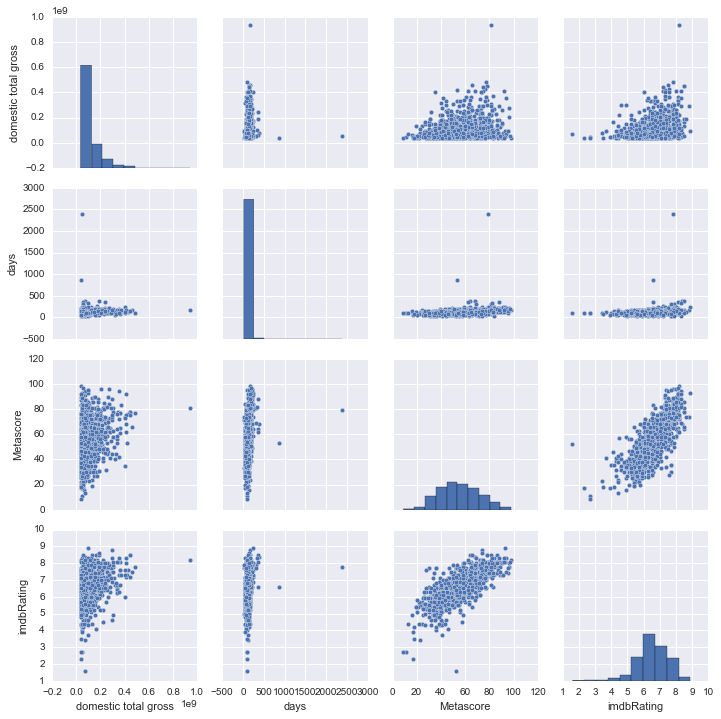

In [107]:
sns.pairplot(df3)

In [1]:
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
lr = LinearRegression()
X = df3[['domestic total gross','Metascore','imdbRating']]
y = df3[['days']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)
lr.summary()

NameError: name 'LinearRegression' is not defined

### Conclusion